Comments:

- The version of Arviz that pyhgf uses currently has an issue with scipy, and it should be downgraded to <0.13.0. This can be done by running `!pip install scipy==0.12.0` in the notebook.
- Graphviz is not automatically installed when installing pyhgf, so it should be installed manually by running `!pip install graphviz` in the notebook.

Just use the YML file from the main Github repo.

# Example 4: Iowa-Gambling Task

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pymc as pm
import seaborn as sns

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import first_level_gaussian_surprise
import numpy as np
import random

set.seed(420)

Similarly to Example 3 (link) we can also fit the Iowa Gambling Task (IGT) using the HGF. IGT is a developed form of a two-armed bandit task, with the key difference being that 1) the rewards are continuous and 2) the magnitude and the frequency of the rewards differs between the arms, or in this case - decks of cards.

In this task, participants have to choose between four decks of cards, each associated with different rewards and punishments. The task is designed to measure decision-making under uncertainty and risk-taking behaviour. The task is typically divided into blocks, and the participant has to learn the reward and punishment probabilities associated with each deck. The task is designed such that two decks are disadvantageous (A and B) and two are advantageous (C and D). The advantageous decks have a higher **total value** compared to the disadvantageous decks.

*insert a picture here illustrating 10 rounds of different decks*

Building on top of Example 3, this notebook will also use missing/unobserved values in the input nodes and custom response functions, with two key additions: the input nodes will now process continuous values and a new parameter will be introduced to model a specific bias in the agent's decision-making, specifically - a preference for decks with high reward frequency.

## Simulating data

### Deck A

Deck A, one of the disadvantageous decks, has a baseline reward of 100, but has a high likelihood (50%) of also containing a punishment of -150 to -350. This means that in 50% of the cases the total reward will 100 and in the other 50% cases it will be 100 - (150 to 350).

In [24]:
num_trials = 100

# Deck 1 - 50% chance of -150 to -350
deck1 = []
for i in range(num_trials):
    x = 100
    # 50% chance of -150 to -350
    if np.random.binomial(1, 0.5) == 1:
        # Randomly choose a value from the list
        x += random.choice([-150, -175, -200, -225, -250, -275, -300, -325, -350])
    else:
        pass
    deck1.append(x)

print(deck1)
print(f"Total value of Deck 1: {sum(deck1)}")

[-75, 100, -75, 100, 100, 100, 100, -75, -200, 100, 100, -75, -175, -100, 100, 100, 100, 100, -250, 100, 100, -50, 100, 100, -250, 100, 100, 100, 100, -250, -175, -75, -200, 100, 100, 100, 100, 100, -175, -200, -50, -150, -150, -175, 100, 100, 100, -75, -250, 100, -125, -100, -225, 100, -125, -75, 100, -175, 100, -250, 100, -175, 100, -75, -150, -125, -200, -250, 100, -250, 100, 100, -50, -150, 100, -50, 100, -100, 100, -150, -150, -175, -175, -50, -100, -100, -200, 100, -75, -100, 100, -50, 100, -75, 100, -250, -125, 100, 100, -200]
Total value of Deck 1: -3375


### Deck B

Deck B, the other disadvantageous deck, has a baseline reward of 100 and a low likelihood (10%) of a high loss of -1250. This means that in 90% of the cases the total reward will be 100 and in 10% of the cases it will be 100 - 1250.

In [25]:
# Deck 2 - 10% chance of -1250
deck2 = []
for i in range(num_trials):
    x = 100
    # 10% chance of -1250
    if np.random.binomial(1, 0.1) == 1:
        x += -1250
    else:
        pass
    deck2.append(x)

print(deck2)
print(f"Total value of Deck 2: {sum(deck2)}")

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, 100, 100, 100, -1150, -1150, -1150, 100, 100, 100, 100, 100, -1150, 100, 100, 100, -1150, 100, -1150, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, 100, -1150, 100, 100, 100, 100, 100, 100, 100]
Total value of Deck 2: -7500


### Deck C

Deck C is one of the advantageous decks and has the same structure as Deck A, but with a baseline reward of 50 and 50% likelihood of a punishment of -25 to -75. Even though its baseline reward is lower than that of Deck A, it has a higher total value due to the lower punishment magnitude.

In [34]:
# Deck 3 - 50% chance of -25 to - 75
deck3 = []
for i in range(num_trials):
    x = 50
    # 50% chance of -25 to -75
    if np.random.binomial(1, 0.5) == 1:
        # Randomly choose a value from the list
        x += random.choice([-25, -50, -75])
    else:
        pass
    deck3.append(x)

print(deck3)
print(f"Total value of Deck 3: {sum(deck3)}")

[50, 50, 25, -25, -25, 25, 50, -25, 0, 25, 50, -25, 50, 50, -25, -25, 50, -25, -25, 25, 50, 0, 0, 50, 25, -25, 50, 0, 50, 0, 0, 50, 50, -25, 50, 25, 50, 0, 50, 25, 50, 0, 25, -25, 50, -25, 50, 50, 50, 50, -25, 25, -25, 50, -25, 0, 25, 50, 50, 50, 25, 50, 0, -25, 0, -25, 50, 50, 50, 50, 25, -25, 50, 0, 50, -25, 0, 50, -25, 25, 50, 25, 25, -25, 50, 50, 0, 25, 50, 50, 0, 50, 25, 50, 25, 25, 50, 50, 50, 50]
Total value of Deck 3: 2200


### Deck D

Deck D is the other advantageous deck, which mirrors the structure of Deck B, but with a baseline reward of 50 and a 10% likelihood of a punishment of -250. Again, even though its baseline reward is lower than that of Deck B, it has a higher total value due to the lower punishment magnitude.

In [35]:
# Deck 4 - 10% chance of -250
deck4 = []
for i in range(num_trials):
    x = 50
    if np.random.binomial(1, 0.1) == 1:
        x += -250
    else:
        pass
    deck4.append(x)

print(deck4)
print(f"Total value of Deck 4: {sum(deck4)}")

[50, 50, -200, 50, 50, 50, 50, 50, 50, -200, 50, -200, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, -200, 50, 50, 50, 50, 50, 50, 50, 50, -200, 50, 50, 50, 50, 50, 50, 50, -200, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, -200, 50, 50, 50, 50, 50, 50, 50, -200, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, -200, 50, 50, 50, -200, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Total value of Deck 4: 2500


### Combining the decks

Below, we combine the decks into a list, standardize the values and plot the time series of the rewards for each deck.

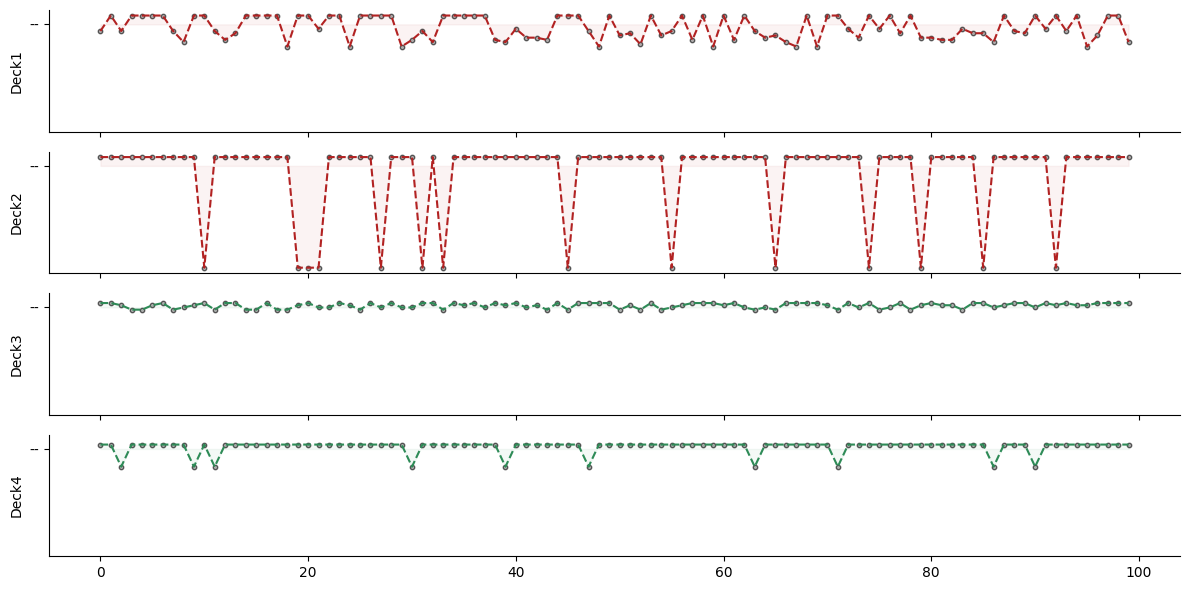

In [42]:
# Standardize the values in the four decks
decks = [deck1, deck2, deck3, deck4]
decks_std = []
for deck in decks:
    deck = (deck - np.mean(deck)) / np.std(deck)
    decks_std.append(deck)

# Visualize the decks
trials = np.arange(len(deck1))

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

for i, u, p, label, color in zip(
    range(4),
    [deck1, deck2, deck3, deck4],
    [deck1, deck2, deck3, deck4],
    ["Deck1", "Deck2", "Deck3", "Deck4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"]):
    axs[i].scatter(trials, u, label="outcomes", alpha=.6, s=10, color="gray", edgecolor="k")
    axs[i].plot(trials, p, "--", color=color)
    axs[i].fill_between(trials, p, "--", label=label, color=color, alpha=.05)
    axs[i].set_ylabel(label)
plt.tight_layout()
sns.despine();

## Model

To model the IGT task, we use a three-level continuous HGF model with the following structure:

1. **input**: the input nodes process the continuous rewards from the decks
2. **x1**: the first node processes the input and computes the expected value of the decks
3. **x2**: the second node is volatility-coupled to the first node and manages the uncertainty in the expected value
3. **x3**: the third node is value-coupled to the second node and affects the mean of the distribution form which x2 samples its value

Importantly, we introduce a new parameter, 'autoconnection_strength' to model the agent's bias towards decks with high reward frequency (insert reference here). This parameter (ranging from 0 to 1) (link) weights the impact of the previous value *k-1* of **x2** on the mean of the distribution from which the current value *k* of **x2** is sampled. 

As **x2** is value-coupled to **x3**, this means that when the *autoconnection_strength* approaches 0, the mean of the distribution of **x2** will be less influenced by the previous value of **x2** and more influenced by the value of **x3**.

(Insert some equations here I guess?)

In practice, this means that whenever there's a highly surprising event (for example a high punishment of -1250 in Deck B), the agent expectation about the volatility in the environment (Deck B) will shoot up, but quickly return to the baseline value due to the decreased influence of previous observation of **x2**. This autoregressive effect is used to model the agent's bias towards decks with high reward frequency. We can hypothesise that *autoconnection_strength* will be generally higher in networks that are fitted to Decks B and D, which have a high reward frequency.

Let's see this in practice.

### Single HGF

Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 100 new observations.


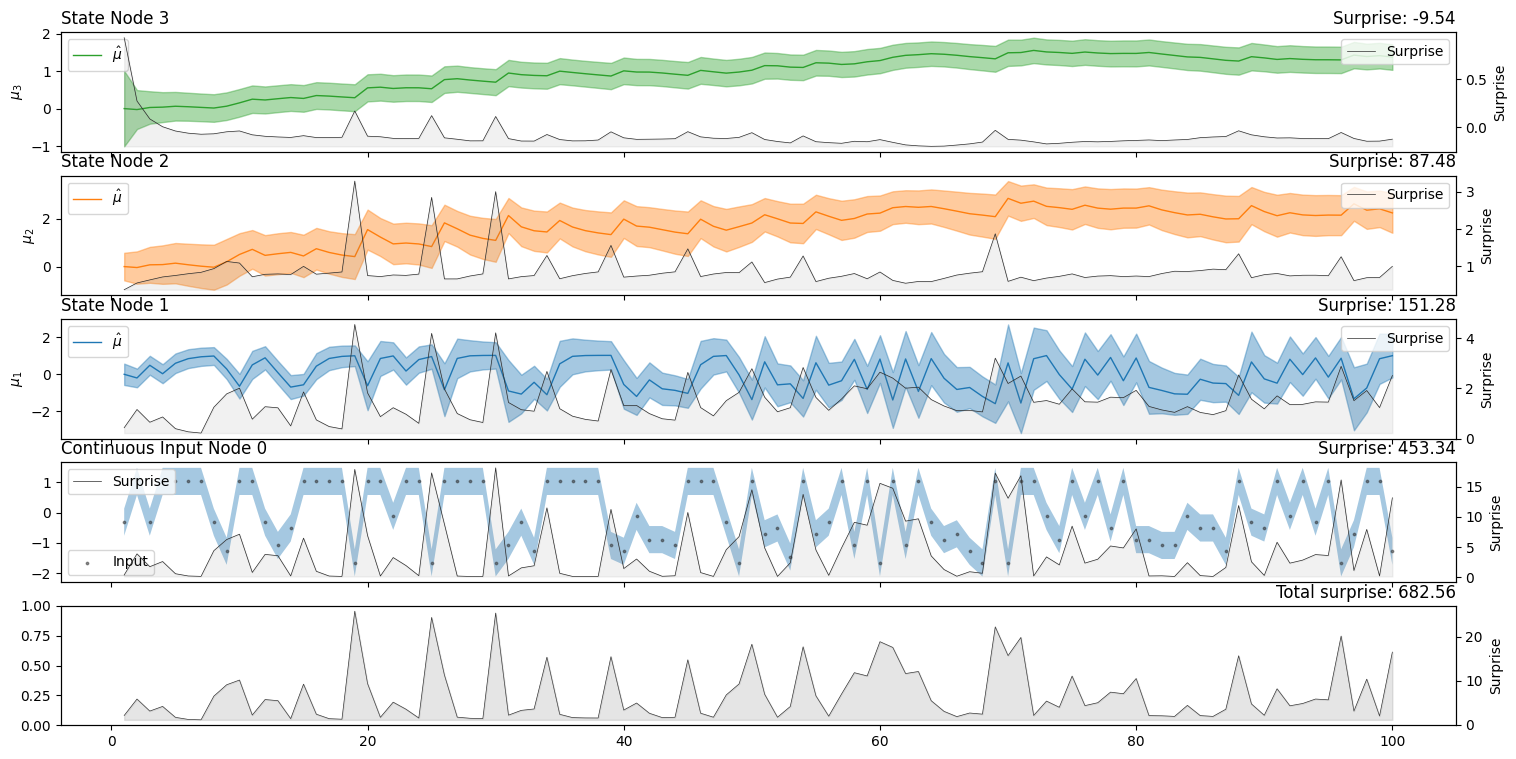

In [86]:
# First we create a single HGF network to model Deck A (50% chance of -150 to -350), with autoconnection strength set to 0.4

two_levels_continuous_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", n_nodes=1, input_precision = 5.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-2.0, precision = 5.0, mean = 0.0)
    .add_nodes(volatility_children=1, tonic_volatility=-2.0, precision = 5.0, autoconnection_strength = 0.4)
    .add_nodes(value_children=2, precision = 1.0)
)

# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=np.asarray(decks_std[0]))

# Plot the node trajectories
two_levels_continuous_hgf.plot_trajectories();

In [88]:
df = two_levels_continuous_hgf.to_pandas()
# Get the last value of the x_1_expected_mean column of df
print(df['x_1_expected_mean'].iloc[-1])

1.0079594


As can be seen in the plot above, the agent's expectation about the volatility in the Deck A more or less smoothly increases as the task progresses, as the agent is constantly (50% of the time) met with negative rewards. Now let's see with Deck B.

Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 100 new observations.


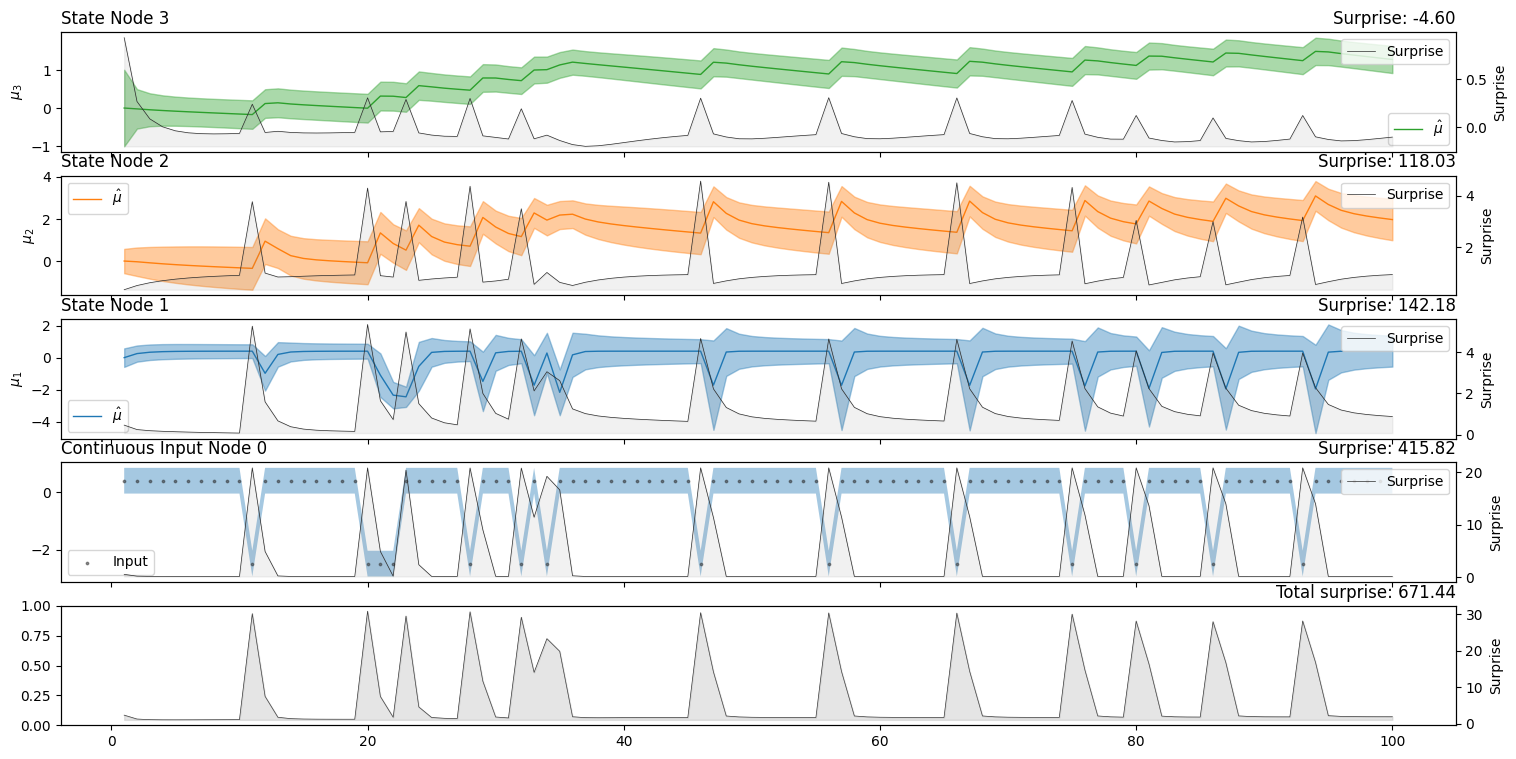

In [89]:
# First we create a single HGF network to model Deck B (10% chance of -1250), with autoconnection strength set to 0.4

two_levels_continuous_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", n_nodes=1, input_precision = 5.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-2.0, precision = 5.0, mean = 0.0)
    .add_nodes(volatility_children=1, tonic_volatility=-2.0, precision = 5.0, autoconnection_strength = 0.4)
    .add_nodes(value_children=2, precision = 1.0)
)

# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=np.asarray(decks_std[1]))

# Plot the node trajectories
two_levels_continuous_hgf.plot_trajectories();

As we can see, the agent's expectation about the value in Deck B returns to the basline value much quicker than in Deck A, as the agent is only met with negative rewards 10% of the time. This is due to the autoregressive effect of the *autoconnection_strength* parameter, which decreases the influence of the previous value of **x2** on the mean of the distribution from which the current value of **x2** is sampled.

# NEXT IS UNFINISHED

# Multiple HGFs

Now we build a model with 4 HGFs, one for each deck. We will use the same parameters for all HGFs.

Initializing a network with custom node structure.


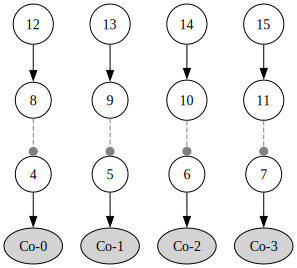

In [110]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
    .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
)

two_levels_continuous_hgf.plot_network()

In [111]:
# Make our input vector
u = np.array([deck1_std, deck2_std, deck3_std, deck4_std])

In [112]:
# Lets feed our hgf the data
two_levels_continuous_hgf.input_data(input_data=u.T);

... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 200 new observations.


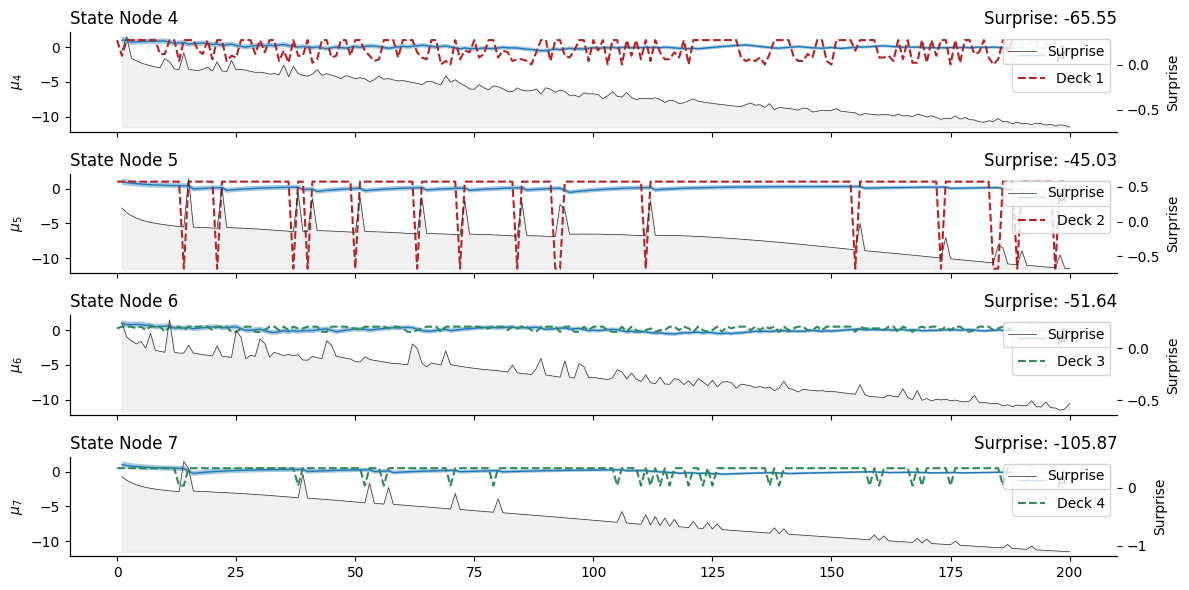

In [113]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [deck1, deck2, deck3, deck4],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")

plt.tight_layout()
sns.despine();

Simulate responses from the participant

In [114]:
# Something wrong with inverse heat here
beta = 1

v_1 = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
v_2 = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
v_3 = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
v_4 = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

def softmax(x, beta):
    """
    Compute the softmax of vector x using an inverse temperature parameter beta.

    Parameters:
    - x: Input vector
    - beta: Inverse temperature parameter

    Returns:
    - Softmax of the input vector x
    """
    x = np.array(x)
    exp_x = np.exp(beta * x)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

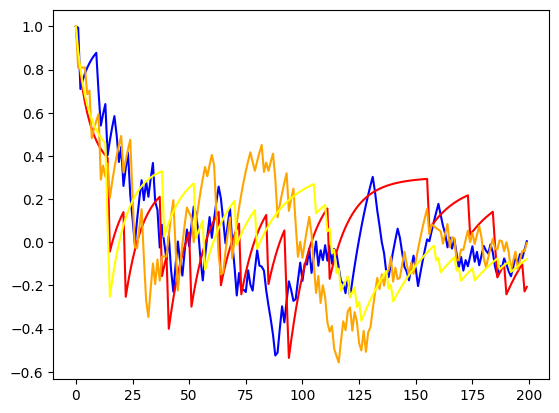

In [115]:
plt.plot(range(len(v_1)), v_1, color = "blue")
plt.plot(range(len(v_1)), v_2, color = "red")
plt.plot(range(len(v_1)), v_3, color = "orange")
plt.plot(range(len(v_1)), v_4, color = "yellow")

In [116]:
# Simulating choices for the participant
choices = []

for i in range(200):
    y = [v_1[i], v_2[i], v_3[i], v_4[i]]
    x = softmax(y, 4)
    choice = np.where(x == max(x))[0][0] # this should be a categorical_logit?
    choice = int(choice)
    choices.append(choice)

In [117]:
# a new matrix of observations
missing_inputs_u = u.astype(float)

# Create an observed array based on the choices made
observed = np.zeros(u.shape)

for i, c in enumerate(choices):
    observed[c, i] = 1

Make a new network

Initializing a network with custom node structure.


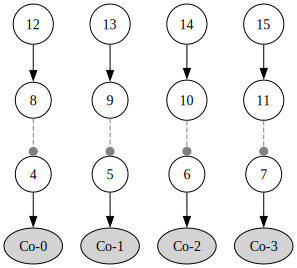

In [118]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
    .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
)

two_levels_continuous_hgf.plot_network()

In [119]:
# note that we are providing the mask as parameter of the input function
two_levels_continuous_hgf.input_data(
    input_data=missing_inputs_u.T,
    observed=observed.T,
);

... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 200 new observations.


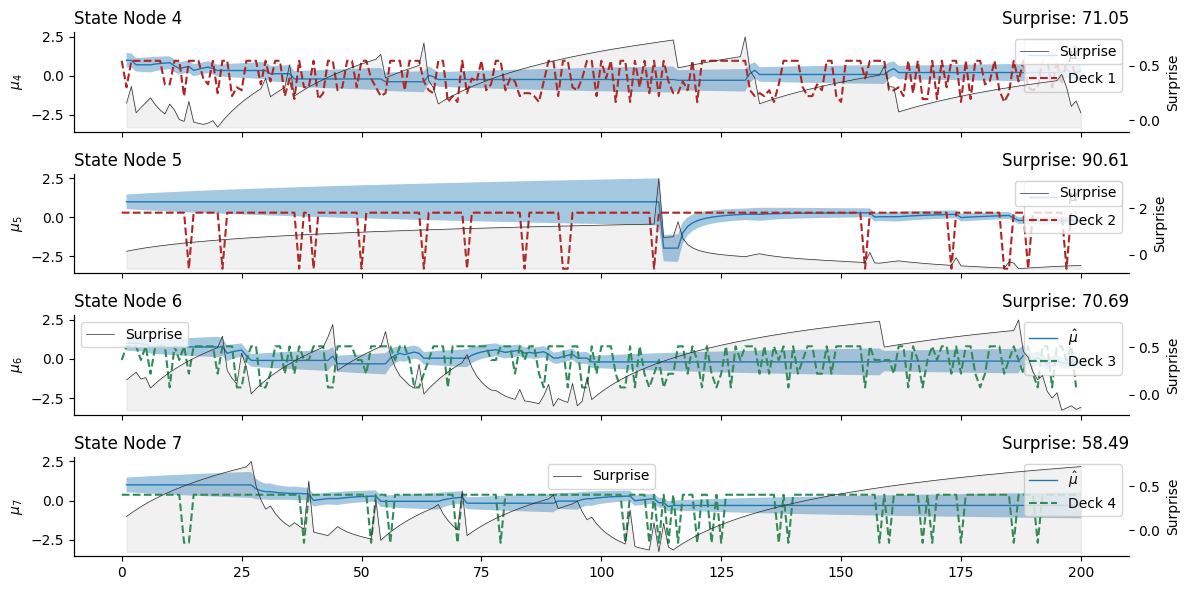

In [120]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [deck1_std, deck2_std, deck3_std, deck4_std],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")

plt.tight_layout()
sns.despine();

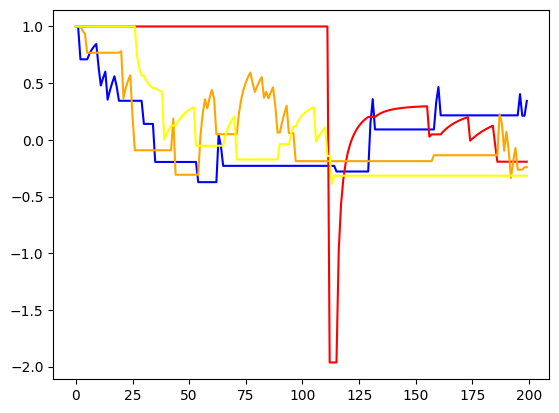

In [121]:
v_1 = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
v_2 = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
v_3 = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
v_4 = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

plt.plot(range(len(v_1)), v_1, color = "blue")
plt.plot(range(len(v_2)), v_2, color = "red")
plt.plot(range(len(v_3)), v_3, color = "orange")
plt.plot(range(len(v_4)), v_4, color = "yellow")

In [88]:
from pyhgf.networks import beliefs_propagation

Initializing a network with custom node structure.


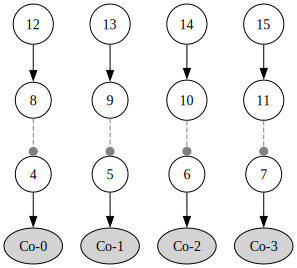

In [89]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
    .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
    .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
    .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
    .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
    .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
)

two_levels_continuous_hgf.plot_network()

In [94]:
# get the network variables from the HGF class
attributes = two_levels_continuous_hgf.attributes
update_sequence = two_levels_continuous_hgf.update_sequence
edges = two_levels_continuous_hgf.edges
input_nodes_idx = two_levels_continuous_hgf.input_nodes_idx.idx

In [95]:
input_data = u.astype(float).T
responses = []  # 1: arm A - 0: arm B

# for each observation
for i in range(input_data.shape[0]):

    # the observation mask - default to 1
    observed = np.ones(4)

    # the time elapsed between two trials - defaults to 1
    time_steps = np.ones(1)

    # the expectations about the outcomes
    d_1 = attributes[4]["expected_mean"]
    d_2 = attributes[5]["expected_mean"]
    d_3 = attributes[6]["expected_mean"]
    d_4 = attributes[7]["expected_mean"]

    y = [d_1, d_2, d_3, d_4]
    x = softmax(y, 4)
    response = np.where(x == max(x))[0][0]
    response = int(response)

    responses.append(response)

    # hide the observations that were not selected
    observed[response] = 1

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        input_data=(input_data[i], time_steps, observed),
        update_sequence=update_sequence,
        edges=edges,
        input_nodes_idx=input_nodes_idx,
    )
responses = jnp.asarray(responses)  # vector of responses

TypeError: 'NoneType' object is not iterable